In [14]:
from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch

from dinov2.data.masking import MaskingGenerator
from dinov2.data.collate import collate_data_and_cast
from dinov2.data import make_data_loader

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    Mlp,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)

from dinov2.data.augmentations import SegmentationAlgo

root = "/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/"
ds_path = f"LMDBDataset:split=TRAIN:root={root}:extra=*"

In [37]:
data_transform_cpu = DataAugmentationDINO(
    [0.32, 0.8],
    [0.05, 0.32],
    local_crops_number=6,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=False,
    use_native_res=False,
    do_seg_crops=None,
    patch_size=14
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=True,
    cache_dataset=False,
)

INFO:dinov2:###################################
INFO:dinov2:Using data augmentation parameters:
INFO:dinov2:global_crops_scale: [0.32, 0.8]
INFO:dinov2:local_crops_scale: [0.05, 0.32]
INFO:dinov2:local_crops_number: 6
INFO:dinov2:global_crops_size: 224
INFO:dinov2:local_crops_size: 96
INFO:dinov2:###################################
/hkfs/home/project/hk-project-p0021769/hgf_auh3910/micromamba/envs/dinov2/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
INFO:dinov2:using dataset: "LMDBDataset:split=TRAIN:root=/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/:extra=*"
INFO:dinov2:# of dataset samples: 305,578


Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/', 'extra': '*'}
extra_full_path /home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/*-TRAIN_*
Datasets labels file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_labels']
Datasets imgs file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs']
/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs lmdb_env_imgs.stat() {'psize': 4096, 'depth': 4, 'branch_pages': 498, 'leaf_pages': 34082, 'overflow_pages': 8486, 'entries': 305578}


img.shape 0 torch.Size([3, 224, 224])
img.shape 1 torch.Size([3, 224, 224])
img.shape 2 torch.Size([3, 3584, 14])
img.shape 3 torch.Size([3, 3584, 14])
img.shape 4 torch.Size([3, 96, 96])
img.shape 5 torch.Size([3, 96, 96])
img.shape 6 torch.Size([3, 96, 96])
img.shape 7 torch.Size([3, 96, 96])
img.shape 8 torch.Size([3, 96, 96])
img.shape 9 torch.Size([3, 96, 96])


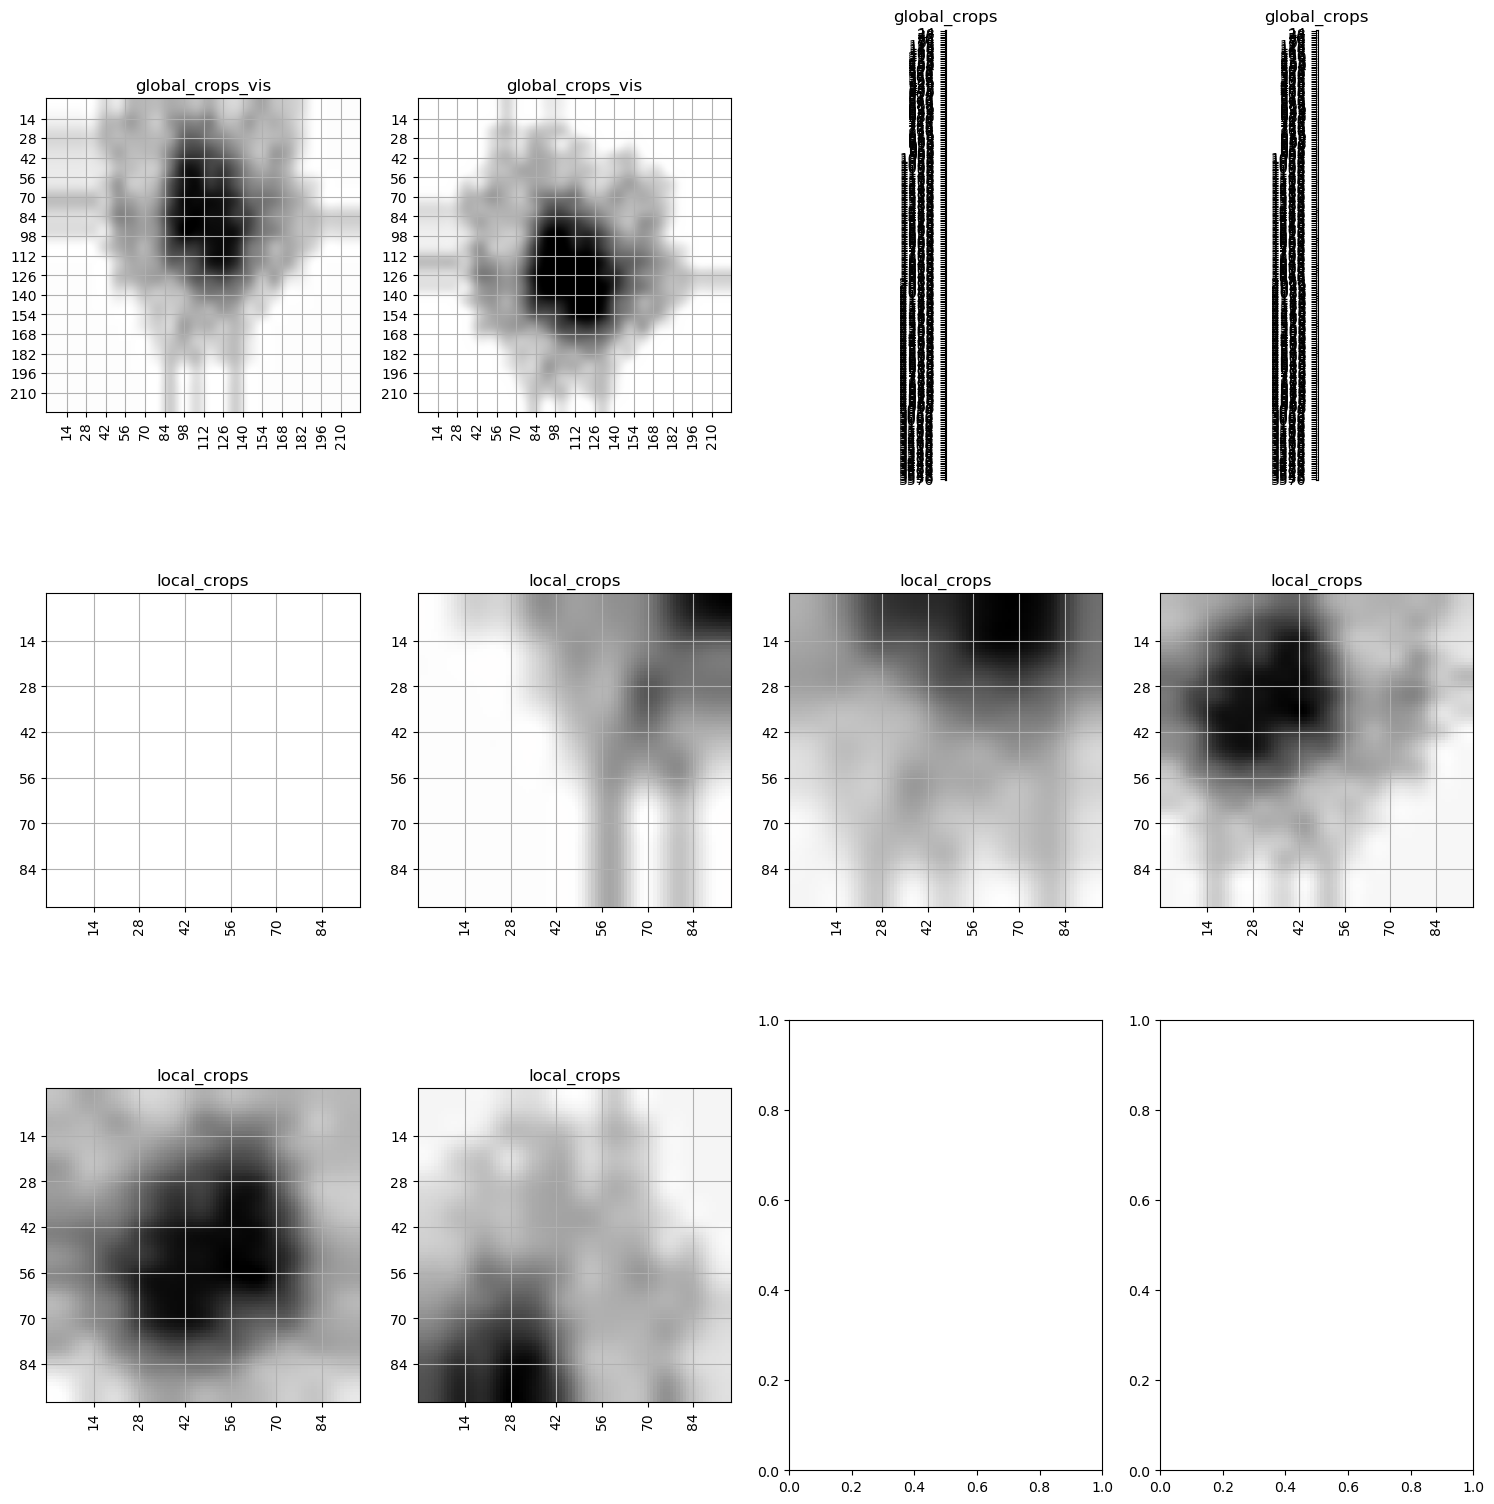

In [51]:

imgs = dataset[2][0]
# dict_keys(['global_crops', 'local_crops', 'offsets'])


do_plot = True
"""
for k in imgs.keys():
    for img in imgs[k]:
        if torch.std(img) < 1e-3:
            print(torch.std(img))
            do_plot = True
            break

    # f2, a2 = plt.subplots(1, 1)
    # plt.hist(img.flatten(), bins=40)
"""
nb_x_plots, nb_y_plots = 3, 4
f, a = plt.subplots(nb_x_plots, nb_y_plots)
f.set_size_inches(15, 15)
f.tight_layout()
count = 0
for k in imgs.keys():
    for img in imgs[k]:
        if len(img.shape) > 3:
            img = img[0]
        if len(img.shape) == 2:
            img = img[None, :, :].repeat((3, 1, 1))
        print("img.shape", count, img.shape)

        norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
        a[count // 4, count % 4].imshow(norm_img.permute(1, 2, 0))
        a[count // 4, count % 4].set_title(k)
        xticks = np.arange(14, norm_img.shape[2], 14)
        yticks = np.arange(14, norm_img.shape[1], 14)
        a[count // 4, count % 4].set_xticks(xticks)
        a[count // 4, count % 4].set_yticks(yticks)
        a[count // 4, count % 4].xaxis.grid(True)
        a[count // 4, count % 4].yaxis.grid(True)
        a[count // 4, count % 4].set_xticklabels(xticks, rotation=90)
        count += 1
        # if count // 4 >= nb_x_plots or count % 4 >= nb_y_plots:
        #     break
    